[Shelter Animal Outcomes](https://www.kaggle.com/c/shelter-animal-outcomes)

In [1]:
reset -fs

## Imports

In [2]:
import pandas as pd
import numpy as np
from collections import Counter

from scipy.stats import norm
from fractions import Fraction
from math import factorial
import itertools
import random

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

sns.set_style("dark", {'axes.grid' : False})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
animals = pd.read_csv('data/train.csv')
animals.head(2)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby


In [4]:
animals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [5]:
# rename columns
animals.columns = [x.lower() for x in animals.columns]
animals = animals.rename(index=str, 
               columns={
                   "animalid": "id",
                   "datetime": "date_outcome",
                   "outcometype": "outcome",
                   "outcomesubtype": "outcome_info",
                   "animaltype": "animal",
                   "sexuponoutcome": "sex_outcome",
                   "ageuponoutcome": "age"})
animals.columns

Index(['id', 'name', 'date_outcome', 'outcome', 'outcome_info', 'animal',
       'sex_outcome', 'age', 'breed', 'color'],
      dtype='object')

# Data cleaning & EDA

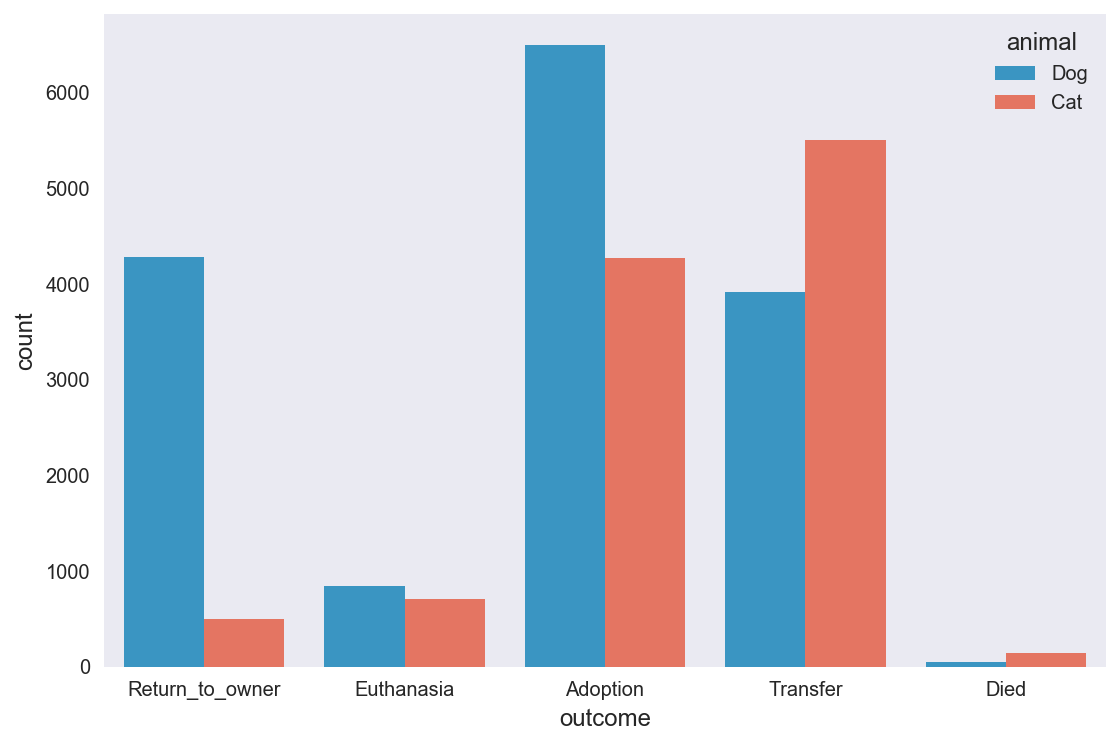

In [6]:
plt.subplots(figsize=(8, 6))
sns.countplot(x="outcome", hue="animal", data=animals, alpha=0.85);

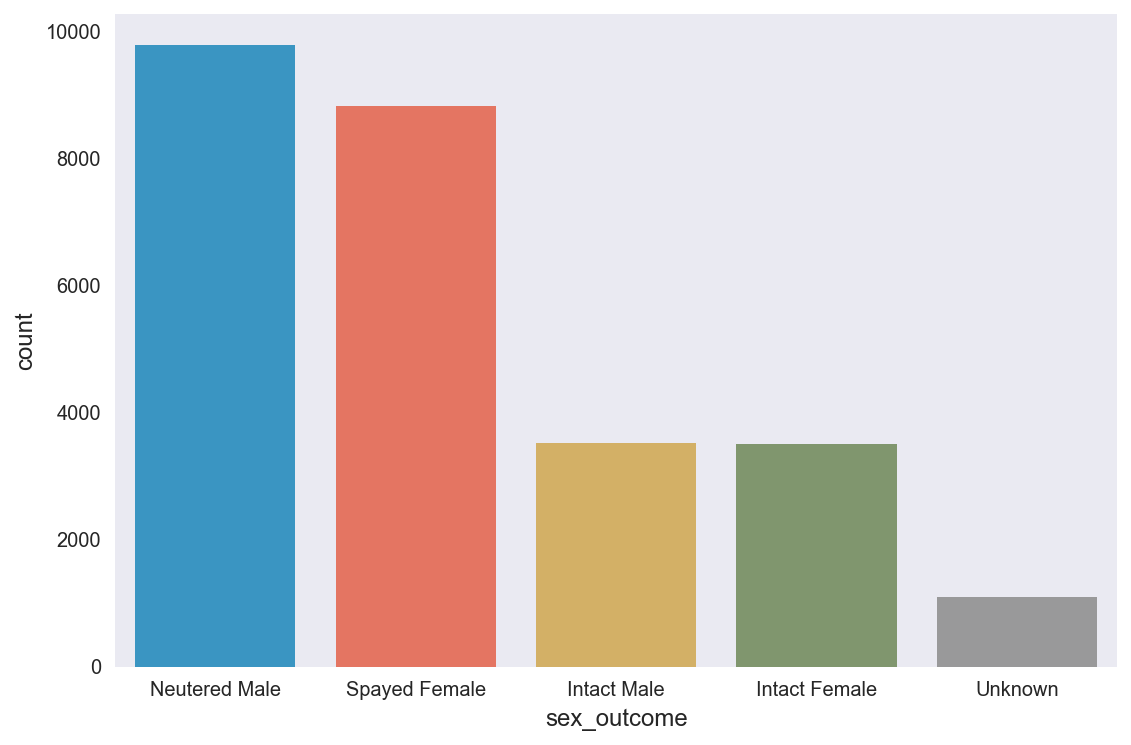

In [7]:
plt.subplots(figsize=(8, 6))
sns.countplot(x="sex_outcome", data=animals, alpha=0.85);

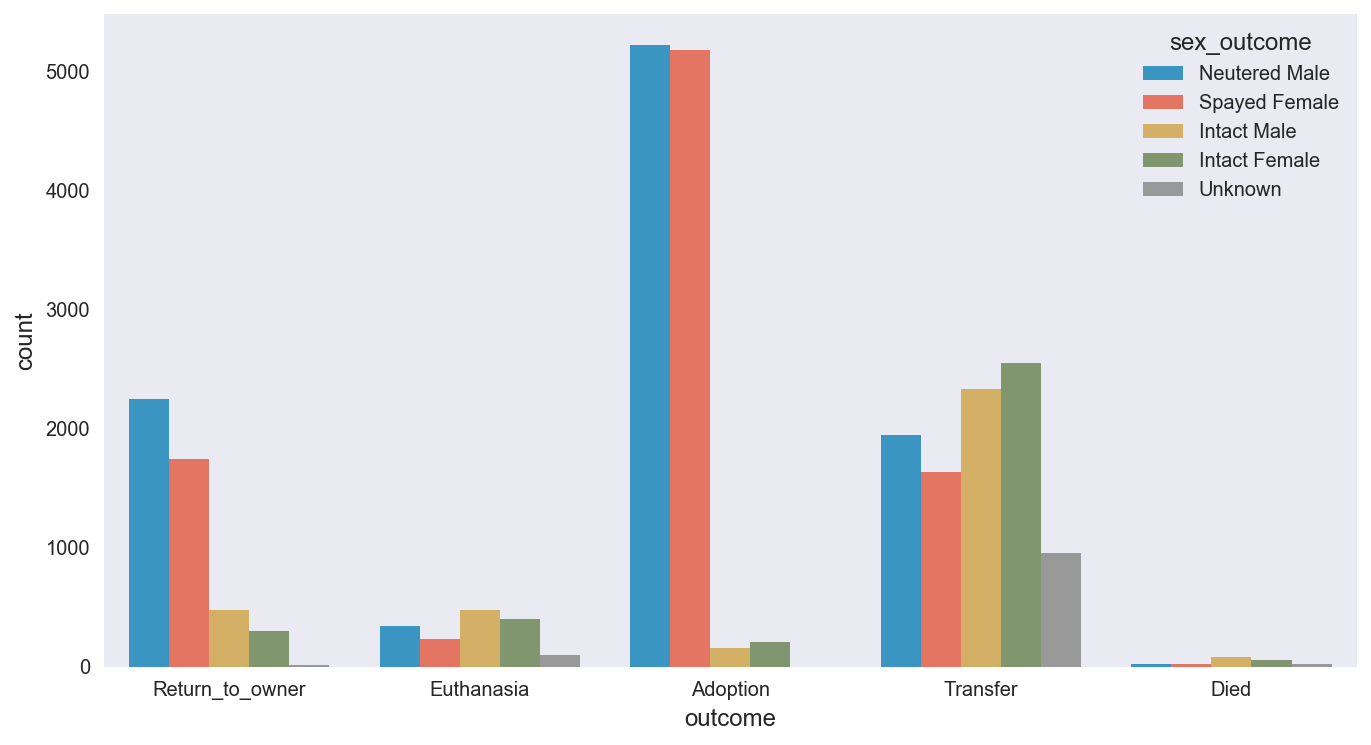

In [8]:
plt.subplots(figsize=(10, 6))
sns.countplot(x="outcome", hue="sex_outcome", data=animals, orient="v", alpha=0.85);

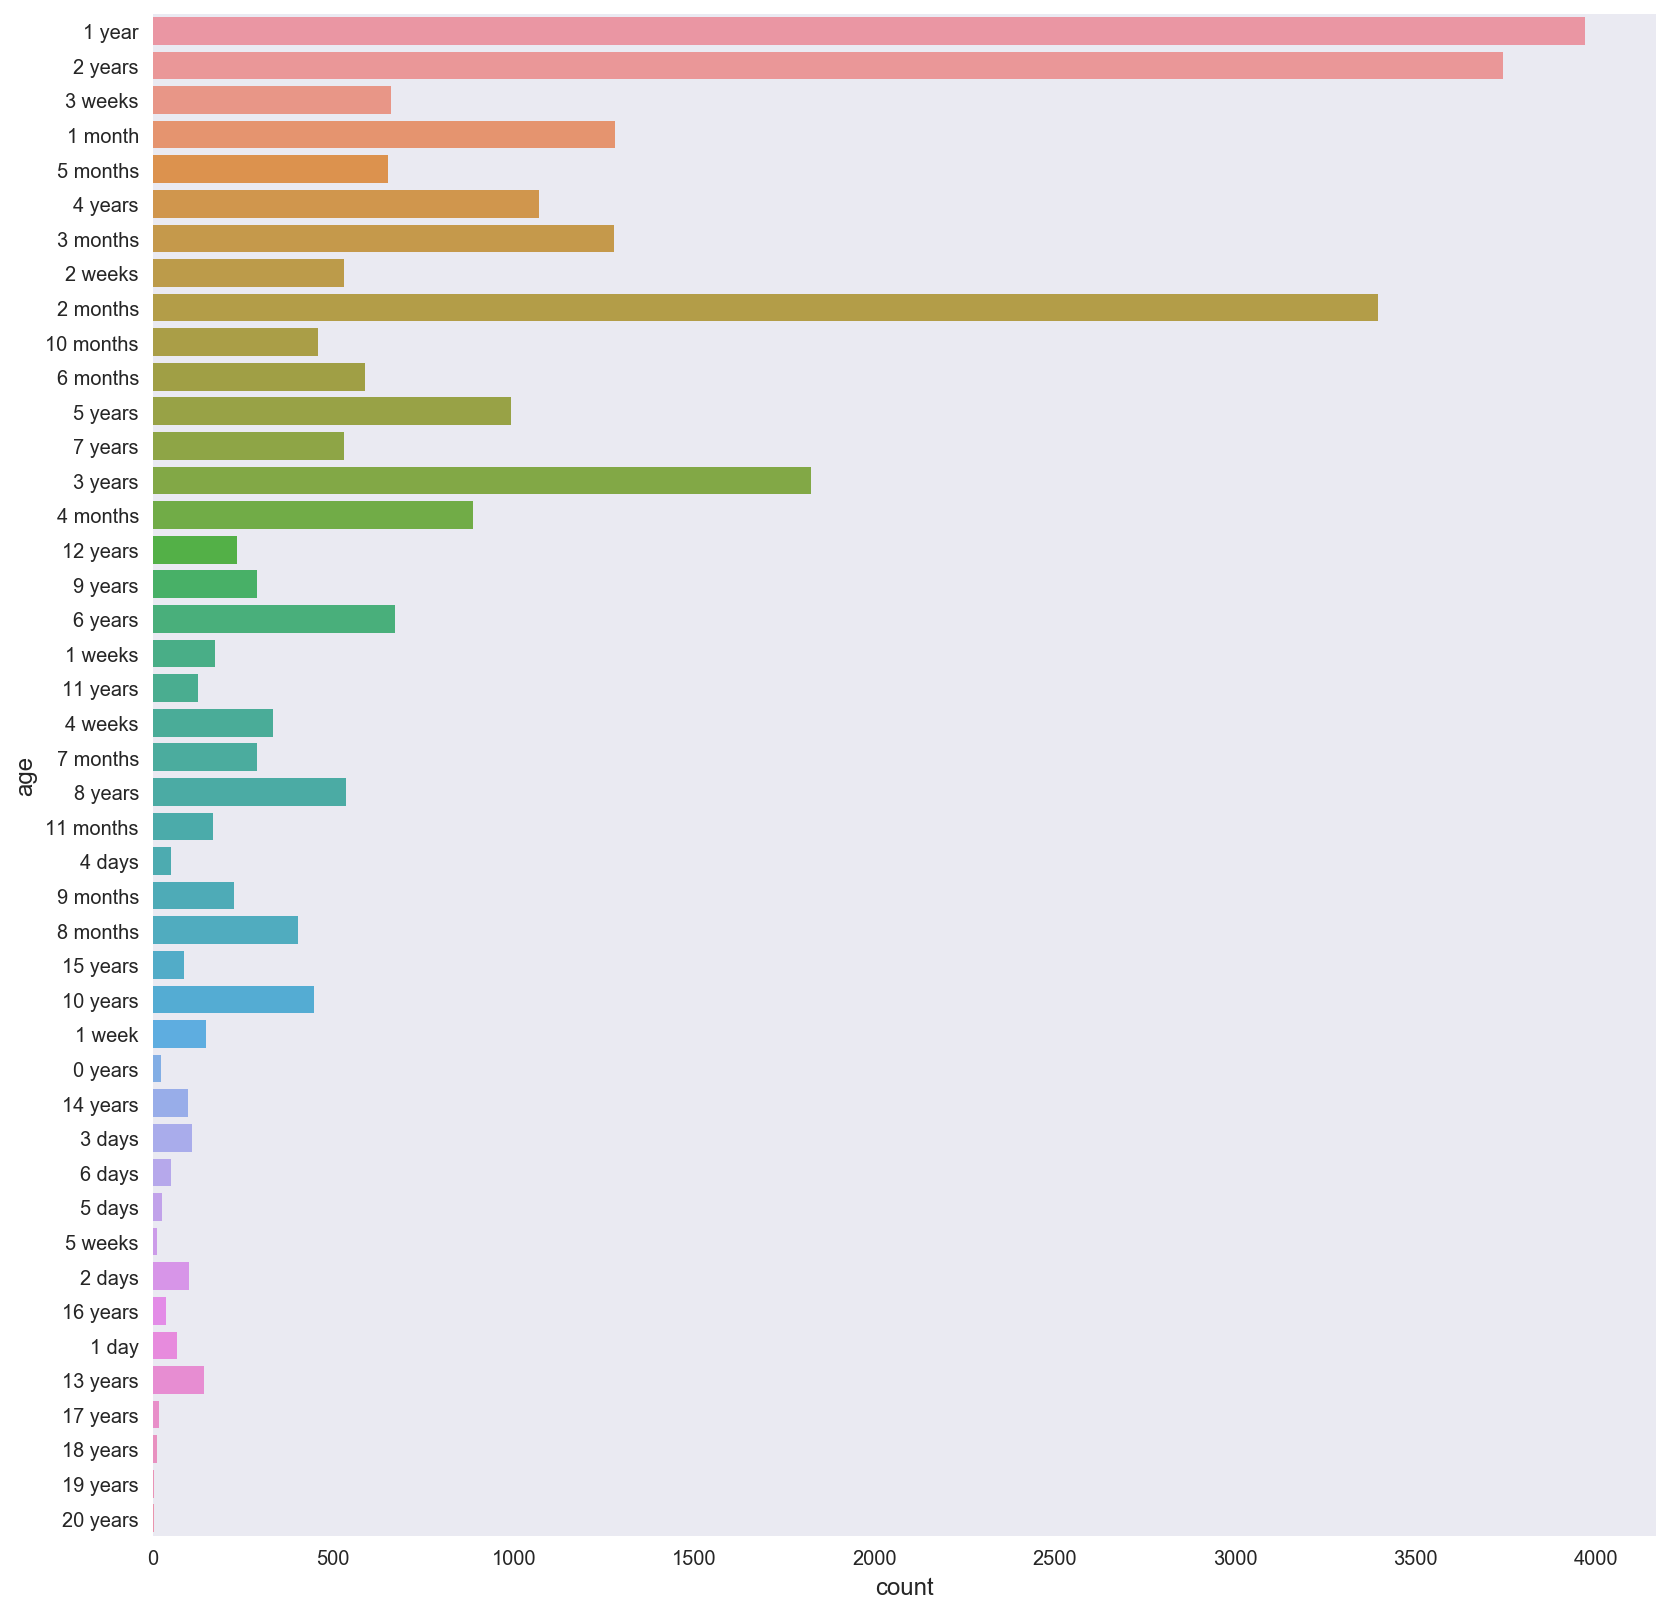

In [9]:
plt.subplots(figsize=(12,14))
sns.countplot(y="age", data=animals);

### Animal
Make new column dog... 0 = cat, 1 = dog

In [10]:
animals.animal.value_counts()

Dog    15595
Cat    11134
Name: animal, dtype: int64

In [11]:
animals['dog'] = animals.animal.apply(lambda row: 0 if 'Cat' in row else 1)

In [12]:
animals.dog.value_counts()

1    15595
0    11134
Name: dog, dtype: int64

### Outcome
To keep things simple make this purely binary 0 = not adopted, 1 = adopted

In [13]:
animals.outcome.value_counts(dropna=False)

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: outcome, dtype: int64

In [14]:
animals['adopted'] = animals.outcome.apply(lambda row: 1 if row == 'Adoption' else 0)

In [15]:
animals.adopted.value_counts(dropna=False)

0    15960
1    10769
Name: adopted, dtype: int64

In [16]:
sum([i for i in animals.outcome.value_counts().tolist() if i != \
    animals.outcome.value_counts().tolist()[0]])

15960

### Name

Some animals come into the shelter with no name 😥 — made a new column for this as well as top 10 most popular names.

In [17]:
len(animals.name.unique())

6375

In [18]:
animals.name.value_counts(dropna=False).head(11)

NaN         7691
Max          136
Bella        135
Charlie      107
Daisy        106
Lucy          94
Buddy         87
Princess      86
Rocky         85
Luna          68
Jack          66
Name: name, dtype: int64

In [19]:
# replace NaN with "unknown"
animals.name.replace(np.nan, 'unknown', inplace=True)
animals.name.value_counts(dropna=False).head(10)

unknown     7691
Max          136
Bella        135
Charlie      107
Daisy        106
Lucy          94
Buddy         87
Princess      86
Rocky         85
Luna          68
Name: name, dtype: int64

In [20]:
# create has_name column - 0 no name, 1 name
animals['has_name'] = animals.name.apply(lambda row: 0 if 'unknown' in row else 1)

In [21]:
animals[['name','has_name']].head()

,name,has_name
0,Hambone,1
1,Emily,1
2,Pearce,1
3,unknown,0
4,unknown,0


In [22]:
top10 = [name for name in animals.name.value_counts().head(11).index.tolist() if name != 'unknown']

def popular_name(row):
    if row in top10:
        return 1
    else:
        return 0

assert popular_name('Jack') == 1

In [23]:
animals['pop_name'] = animals.name.apply(popular_name)

In [24]:
animals.pop_name.value_counts()

0    25759
1      970
Name: pop_name, dtype: int64

In [25]:
sum(animals.name.value_counts().head(11)) - len(animals[animals.name == 'unknown'])

970

### Sex and spayed/neutered
Made new columns for sex, spayed/neutered... drop unknowns

In [26]:
animals.sex_outcome.value_counts(dropna=False)

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
NaN                 1
Name: sex_outcome, dtype: int64

In [27]:
# make "Unknown" NaN for dropping
animals.sex_outcome.replace('Unknown', np.nan, inplace=True)

In [28]:
animals.shape

(26729, 14)

In [29]:
animals.dropna(subset=['sex_outcome'],inplace=True)
animals.reset_index(drop=True, inplace=True)

In [30]:
animals.shape

(25635, 14)

In [31]:
animals['sex'] = animals.sex_outcome.apply(lambda row: 1 if 'Female' in row else 0)
animals['spay_neutered'] = animals.sex_outcome.apply(lambda row: 0 if 'Intact' in row else 1)

In [32]:
animals.sex.value_counts(dropna=False)

0    13304
1    12331
Name: sex, dtype: int64

In [33]:
animals.spay_neutered.value_counts(dropna=False)

1    18599
0     7036
Name: spay_neutered, dtype: int64

### Date of outcome
Convert string date to datetime and create columns for day, month, year

In [34]:
animals['datetime'] = pd.to_datetime(animals['date_outcome'], infer_datetime_format=True)

In [35]:
# Monday is 0, Sunday is 6
animals['day'] = animals['datetime'].apply(lambda row: row.weekday())
# 1-12
animals['month'] = animals['datetime'].apply(lambda row: row.month)
#2013-2016
animals['year'] = animals['datetime'].apply(lambda row: row.year)
# split into morning, afternoon, evening
animals['hour'] = animals['datetime'].apply(lambda row: row.hour)
# to investigate when hour = 0
animals['minutes'] = animals['datetime'].apply(lambda row: row.minute)

In [36]:
animals.hour.value_counts(dropna=False).sort_index()

0      364
5        1
6        9
7      109
8      292
9     1057
10     375
11    1997
12    2442
13    2373
14    2670
15    2573
16    2612
17    4058
18    3562
19    1024
20      74
21      18
22       5
23      20
Name: hour, dtype: int64

In [37]:
# 00:00:00 is ambiguous and could midnight or first thing in the morning 
# or essentially be a missing value
animals.datetime.value_counts().head(10)

2015-08-11 00:00:00    19
2015-11-17 00:00:00    17
2015-07-02 00:00:00    13
2015-04-02 00:00:00    11
2014-08-31 09:00:00    10
2015-11-23 00:00:00     9
2016-02-15 00:00:00     9
2015-09-11 00:00:00     9
2015-09-01 00:00:00     8
2015-11-08 00:00:00     8
Name: datetime, dtype: int64

In [38]:
animals[(animals['hour']==0) & (animals['minutes']==0)]

,id,name,date_outcome,outcome,outcome_info,animal,sex_outcome,age,breed,color,...,has_name,pop_name,sex,spay_neutered,datetime,day,month,year,hour,minutes
36,A702655,Mica,2015-08-11 00:00:00,Transfer,Partner,Cat,Neutered Male,4 months,Domestic Shorthair Mix,Black/White,...,1,0,0,1,2015-08-11,1,8,2015,0,0
110,A713392,Basil,2015-11-05 00:00:00,Transfer,Partner,Dog,Intact Male,3 months,Chihuahua Shorthair Mix,Black/White,...,1,0,0,0,2015-11-05,3,11,2015,0,0
167,A710071,Herb,2015-09-01 00:00:00,Transfer,Partner,Cat,Neutered Male,2 months,Domestic Shorthair Mix,White/Black,...,1,0,0,1,2015-09-01,1,9,2015,0,0
173,A716575,Scarlet,2015-12-22 00:00:00,Transfer,Partner,Dog,Spayed Female,2 years,Australian Cattle Dog Mix,Tan/White,...,1,0,1,1,2015-12-22,1,12,2015,0,0
187,A683666,unknown,2015-09-01 00:00:00,Transfer,Partner,Cat,Neutered Male,1 year,Domestic Shorthair Mix,White/Cream Tabby,...,0,0,0,1,2015-09-01,1,9,2015,0,0
239,A709067,Earlene,2015-08-05 00:00:00,Return_to_owner,NaN,Dog,Intact Female,5 months,Boxer Mix,Black/White,...,1,0,1,0,2015-08-05,2,8,2015,0,0
242,A720190,Little Missy,2016-02-07 00:00:00,Transfer,Partner,Dog,Spayed Female,7 years,Airedale Terrier Mix,Tricolor,...,1,0,1,1,2016-02-07,6,2,2016,0,0
278,A714820,Lizzie,2015-11-05 00:00:00,Transfer,Partner,Dog,Spayed Female,6 months,Plott Hound Mix,Brown Brindle,...,1,0,1,1,2015-11-05,3,11,2015,0,0
295,A716488,unknown,2015-11-23 00:00:00,Transfer,Partner,Dog,Neutered Male,2 years,Pit Bull Mix,Red,...,0,0,0,1,2015-11-23,0,11,2015,0,0
395,A716400,Calliope,2015-11-24 00:00:00,Transfer,Partner,Dog,Intact Female,1 year,Yorkshire Terrier Mix,Black/Tan,...,1,0,1,0,2015-11-24,1,11,2015,0,0


In [39]:
# so only 3 rows are times where hour = 0 and minutes !=0
# I'll drop these rows
print(animals[(animals['hour']==0) & (animals['minutes']==0)].shape)
print(animals[(animals['hour']==0) & (animals['minutes']!=0)].shape)

(361, 22)
(3, 22)


In [40]:
# make "Unknown" NaN for dropping
animals.hour.replace(0, np.nan, inplace=True)

In [41]:
animals.dropna(subset=['hour'],inplace=True)

In [42]:
def season(row):
    if row == 3 or row == 4 or row == 5:
        season = 'spring'
    elif row == 6 or row == 7 or row == 8:
        season = 'summer'
    elif row == 9 or row == 10 or row == 11:
        season = 'fall'
    else:
        season = 'winter'
    return season

assert season(12) == 'winter'

In [43]:
animals['season'] = animals.month.apply(season)

In [44]:
animals.hour.value_counts(dropna=False).sort_index(ascending=True)

5.0        1
6.0        9
7.0      109
8.0      292
9.0     1057
10.0     375
11.0    1997
12.0    2442
13.0    2373
14.0    2670
15.0    2573
16.0    2612
17.0    4058
18.0    3562
19.0    1024
20.0      74
21.0      18
22.0       5
23.0      20
Name: hour, dtype: int64

In [45]:
def time_of_day(row):
    if row >= 5 and row < 12:
        time = 'morning'
    elif row >= 12 and row < 17:
        time = 'afternoon'
    else:
        time = 'evening'
    return time

assert time_of_day(6) == 'morning'

In [46]:
animals['time_of_day'] = animals.month.apply(time_of_day)

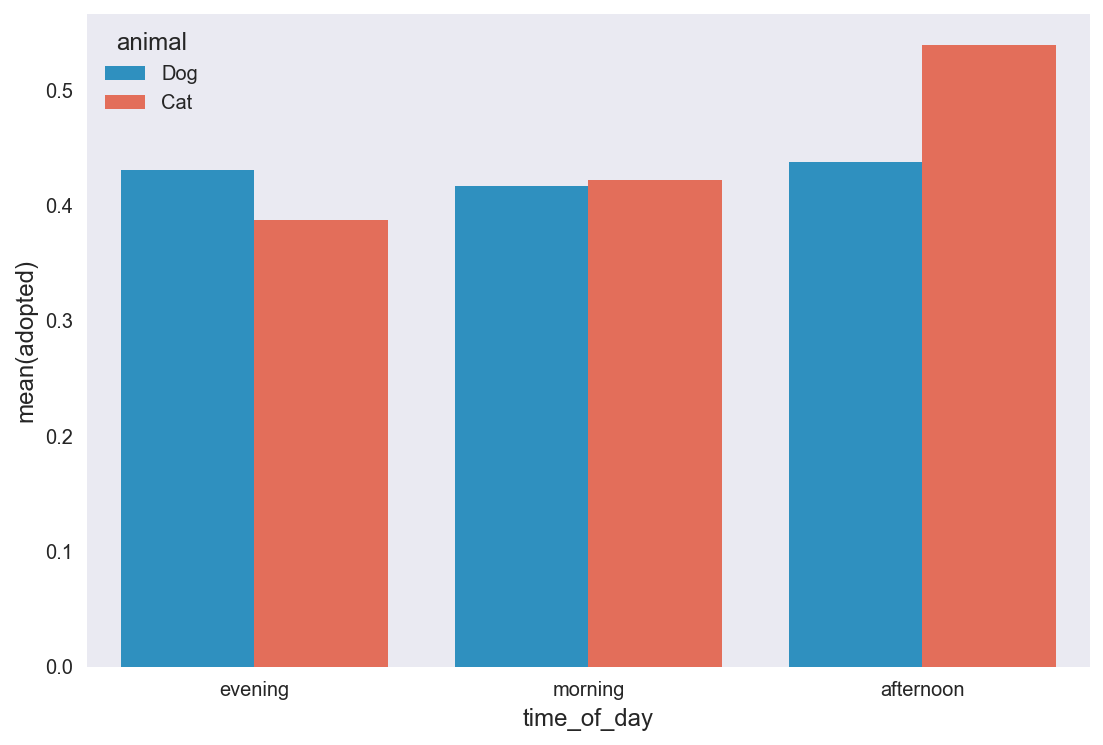

In [47]:
plt.subplots(figsize=(8, 6))
sns.barplot(x="time_of_day", y="adopted", hue='animal', data=animals, alpha=0.9, ci = None);

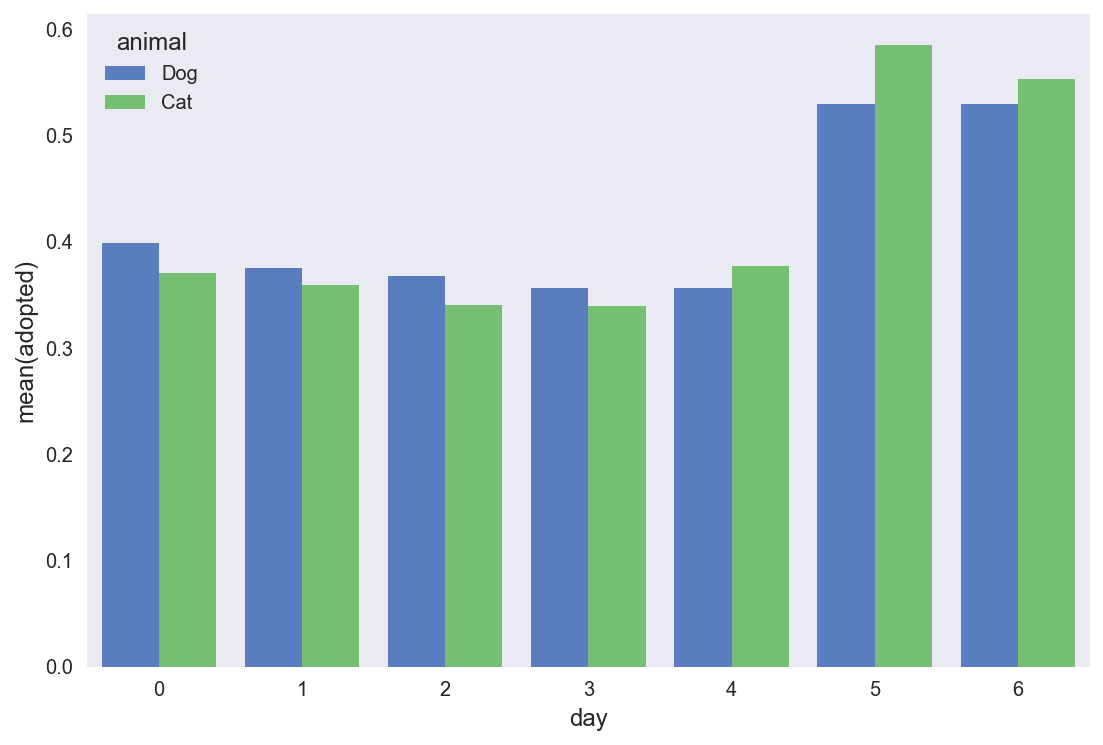

In [48]:
# Monday is 0, Sunday is 6
plt.subplots(figsize=(8, 6))
sns.barplot(x="day", y="adopted", hue="animal", data=animals, palette='muted', ci = None);

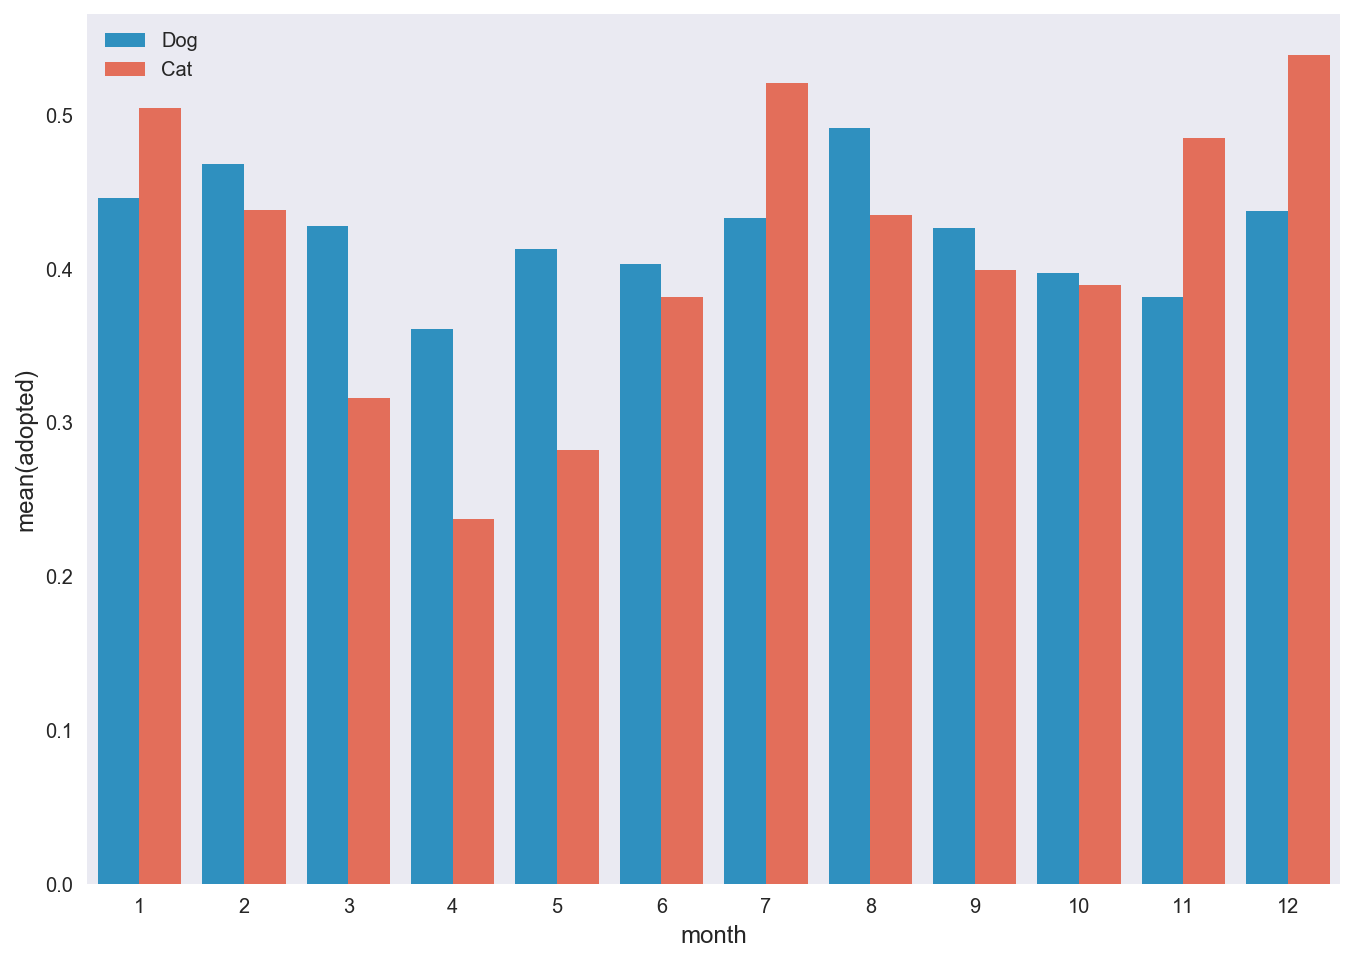

In [49]:
plt.subplots(figsize=(10, 8))
sns.barplot(x="month", y="adopted", hue="animal", data=animals, alpha=0.9, ci = None)
plt.legend(loc='upper left');

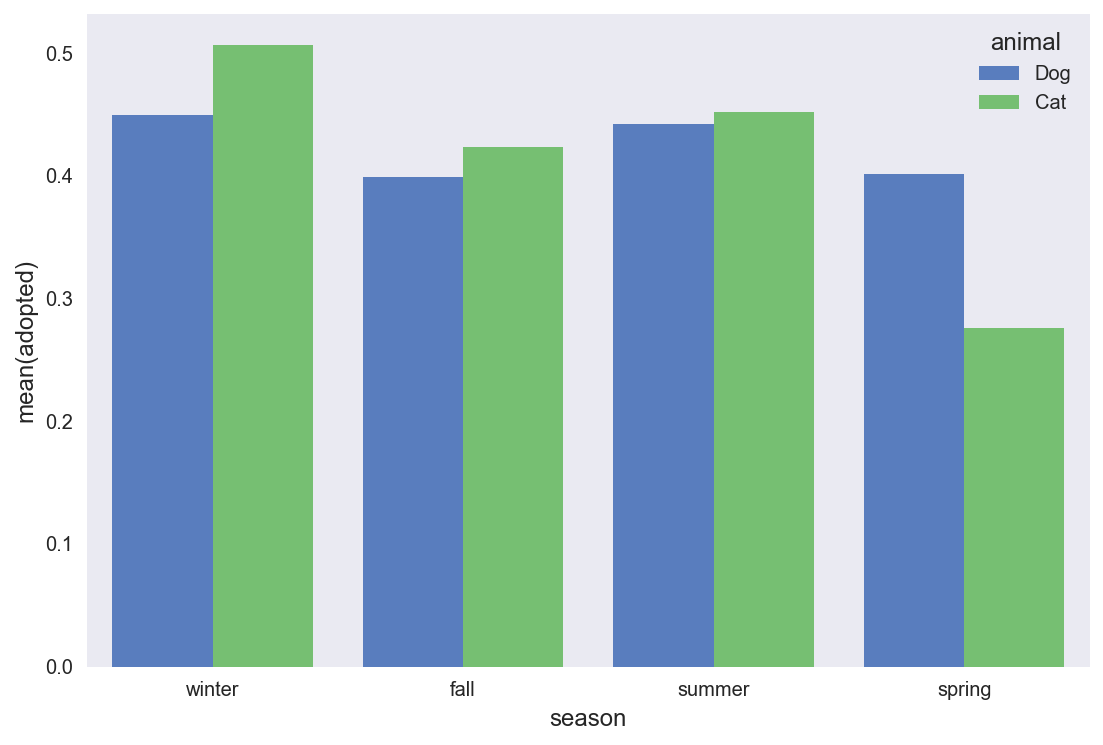

In [50]:
plt.subplots(figsize=(8, 6))
sns.barplot(x="season", y="adopted", hue="animal", data=animals, palette='muted', ci = None);

### Outcome info

After examining this variable I've come to the conclusion it's not useful as it's information explaining the details of the Outcome after the fact so I won't include it in any modeling.

In [51]:
# good number of NaNs
animals.outcome_info.value_counts(dropna=False)

NaN                    13540
Partner                 6866
Foster                  1798
SCRP                    1292
Suffering                910
Aggressive               318
Offsite                  164
In Kennel                 98
Behavior                  86
Rabies Risk               69
Medical                   63
In Foster                 48
Court/Investigation        6
At Vet                     4
Enroute                    4
In Surgery                 3
Barn                       2
Name: outcome_info, dtype: int64

In [52]:
animals[['outcome', 'outcome_info']]

,outcome,outcome_info
0,Return_to_owner,NaN
1,Euthanasia,Suffering
2,Adoption,Foster
3,Transfer,Partner
4,Transfer,Partner
5,Transfer,Partner
6,Transfer,Partner
7,Adoption,NaN
8,Adoption,Offsite
9,Adoption,NaN


In [53]:
animals[['id']].groupby([animals['outcome'], animals['outcome_info']]).count()

id
outcome    outcome_info             
Adoption   Barn                    1
           Foster               1798
           Offsite               164
Died       At Vet                  4
           Enroute                 4
           In Foster              48
           In Kennel              98
           In Surgery              3
Euthanasia Aggressive            318
           Behavior               86
           Court/Investigation     6
           Medical                63
           Rabies Risk            69
           Suffering             910
Transfer   Barn                    1
           Partner              6866
           SCRP                 1292

In [54]:
animals[['id']].groupby([animals['outcome'], animals['outcome_info']]).count().unstack()

id                                                   \
outcome_info Aggressive At Vet Barn Behavior Court/Investigation Enroute   
outcome                                                                    
Adoption            NaN    NaN  1.0      NaN                 NaN     NaN   
Died                NaN    4.0  NaN      NaN                 NaN     4.0   
Euthanasia        318.0    NaN  NaN     86.0                 6.0     NaN   
Transfer            NaN    NaN  1.0      NaN                 NaN     NaN   

                                                                             \
outcome_info  Foster In Foster In Kennel In Surgery Medical Offsite Partner   
outcome                                                                       
Adoption      1798.0       NaN       NaN        NaN     NaN   164.0     NaN   
Died             NaN      48.0      98.0        3.0     NaN     NaN     NaN   
Euthanasia       NaN       NaN       NaN        NaN    63.0     NaN     NaN   
Transfer         NaN       NaN       NaN        NaN     NaN     NaN  6866.0   

                                            
outcome_info Rabies Risk    SCRP Suffering  
outcome                                     
Adoption             NaN     NaN       NaN  
Died                 NaN     NaN       NaN  
Euthanasia          69.0     NaN     910.0  
Transfer             NaN  1292.0       NaN

In [55]:
animals[['id']].groupby([animals['outcome'], animals['outcome_info'].isnull()]).count()

id
outcome         outcome_info      
Adoption        False         1963
                True          8769
Died            False          157
                True            11
Euthanasia      False         1452
                True             1
Return_to_owner True          4753
Transfer        False         8159
                True             6

In [56]:
animals[['outcome', 'outcome_info']][animals['outcome_info'].isnull()].head(10)

,outcome,outcome_info
0,Return_to_owner,NaN
7,Adoption,NaN
9,Adoption,NaN
11,Return_to_owner,NaN
12,Return_to_owner,NaN
17,Return_to_owner,NaN
20,Adoption,NaN
21,Adoption,NaN
22,Return_to_owner,NaN
24,Adoption,NaN


### Age

In [57]:
len(animals.age.unique())

45

In [58]:
# drop NaN and 0 years
animals.age.value_counts(dropna=False)

1 year       3788
2 years      3599
2 months     3331
3 years      1788
3 months     1231
1 month      1230
4 years      1047
5 years       972
4 months      851
6 years       656
5 months      632
6 months      563
8 years       529
3 weeks       528
7 years       521
10 years      442
10 months     442
8 months      371
2 weeks       359
9 years       283
7 months      281
4 weeks       280
12 years      232
9 months      218
11 months     161
13 years      141
11 years      125
1 weeks       114
14 years       96
15 years       85
1 week         66
2 days         60
3 days         55
4 days         38
16 years       34
1 day          24
6 days         21
17 years       17
NaN            14
5 days         11
5 weeks        11
18 years       10
0 years         9
19 years        3
20 years        2
Name: age, dtype: int64

In [59]:
animals.age.replace('0 years', np.nan, inplace=True)

In [60]:
animals.shape

(25271, 24)

In [61]:
animals.dropna(subset=['age'],inplace=True)
animals.reset_index(drop=True, inplace=True)

In [62]:
animals.shape

(25248, 24)

In [63]:
def age_in_weeks(row): 
    if row.find('day') > 0:
        num = int(row.split(' ')[0]) / 7
    elif row.find('week') > 0:
        num = int(row.split(' ')[0])
    elif row.find('month') > 0:
        num = int(row.split(' ')[0]) * 4
    elif row.find('year') > 0:
        num = int(row.split(' ')[0]) * 52
    else:
        num = 'unknown'
    return num

assert age_in_weeks('1 day') == 1/7
assert age_in_weeks('6 days') == 6/7

In [64]:
animals['age_in_weeks'] = animals.age.apply(age_in_weeks)

In [65]:
# verify
animals[['age','age_in_weeks']].head(50)

,age,age_in_weeks
0,1 year,52.0
1,1 year,52.0
2,2 years,104.0
3,3 weeks,3.0
4,2 years,104.0
5,1 month,4.0
6,3 weeks,3.0
7,5 months,20.0
8,1 year,52.0
9,2 years,104.0


In [66]:
assert age_in_weeks(animals.age[10]) == 208

In [67]:
animals.age_in_weeks.value_counts(dropna=False)

52.000000      3788
104.000000     3599
8.000000       3331
156.000000     1788
4.000000       1510
12.000000      1231
208.000000     1047
260.000000      972
16.000000       851
312.000000      656
20.000000       632
24.000000       563
416.000000      529
3.000000        528
364.000000      521
520.000000      442
40.000000       442
32.000000       371
2.000000        359
468.000000      283
28.000000       281
624.000000      232
36.000000       218
1.000000        180
44.000000       161
676.000000      141
572.000000      125
728.000000       96
780.000000       85
0.285714         60
0.428571         55
0.571429         38
832.000000       34
0.142857         24
0.857143         21
884.000000       17
5.000000         11
0.714286         11
936.000000       10
988.000000        3
1040.000000       2
Name: age_in_weeks, dtype: int64

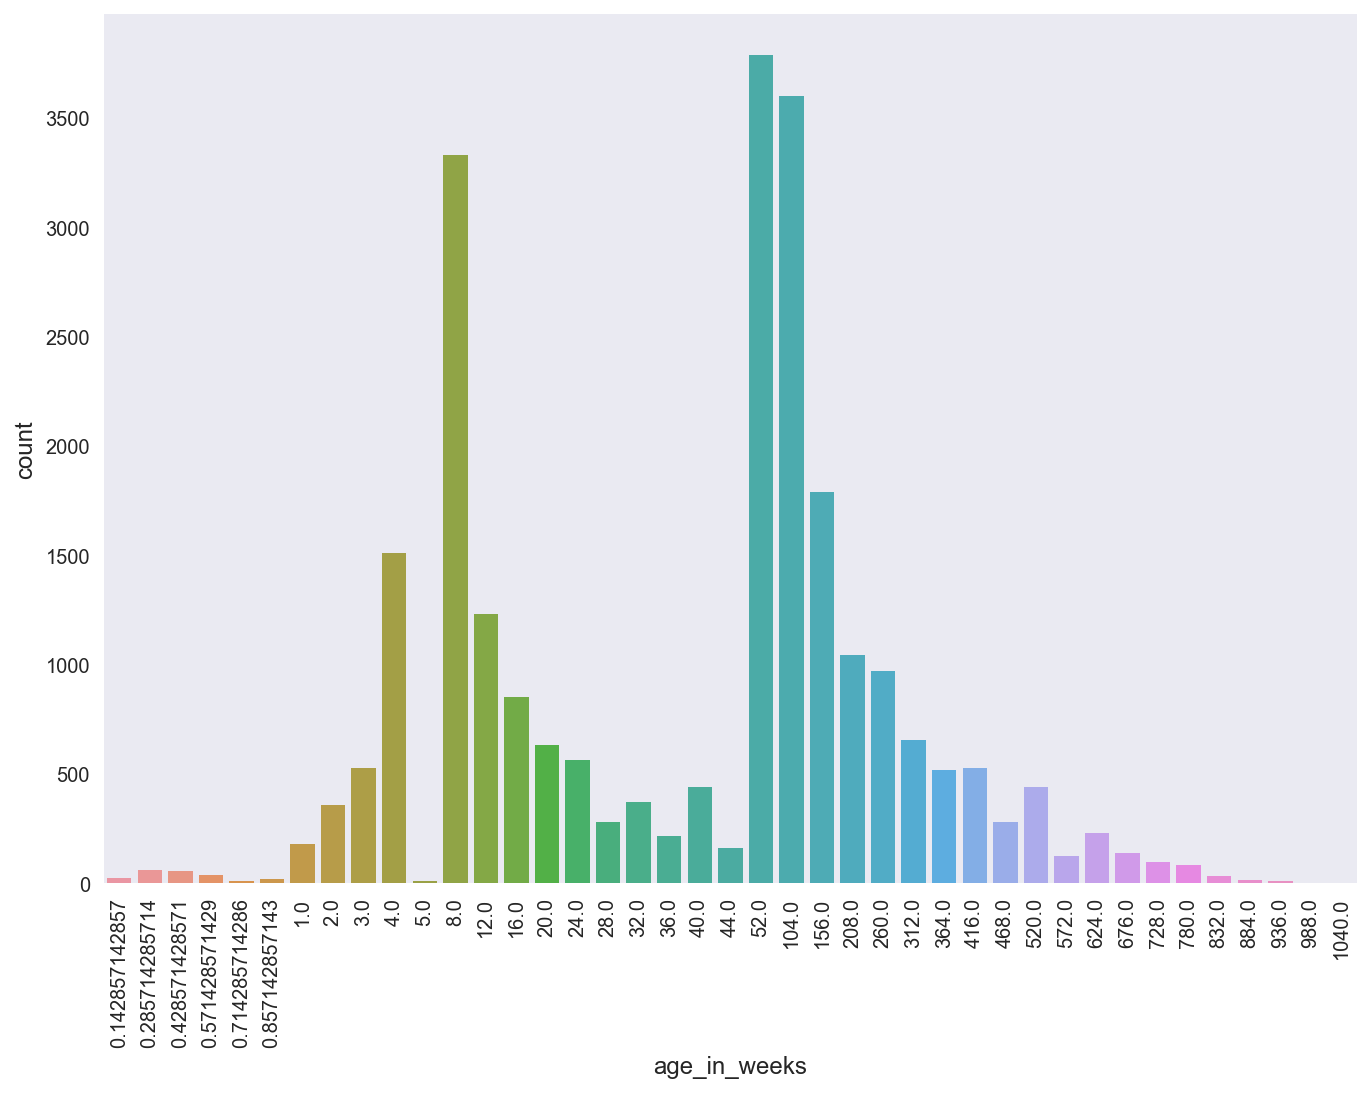

In [68]:
plt.subplots(figsize=(10,8))
sns.countplot(animals.age_in_weeks, data=animals)
plt.xticks(rotation=90);

In [69]:
animals.age_in_weeks.describe()

count    25248.000000
mean       116.645307
std        156.473298
min          0.142857
25%         12.000000
50%         52.000000
75%        156.000000
max       1040.000000
Name: age_in_weeks, dtype: float64

In [70]:
μ, σ = norm.fit(animals.age_in_weeks)
"μ = {:.2f}, σ = {:.2f}".format(μ, σ)

'μ = 116.65, σ = 156.47'

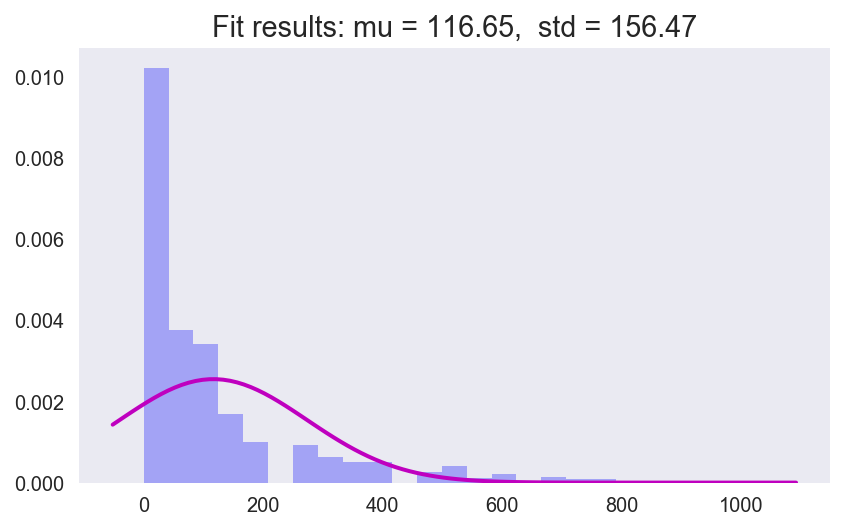

In [71]:
# kinda looks like a beta dist?!

plt.hist(animals['age_in_weeks'], bins=25, normed=True, alpha=0.3, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, μ, σ)
plt.plot(x, p, 'm', linewidth=2);
title = "Fit results: mu = {:.2f},  std = {:.2f}".format(μ, σ)
plt.title(title);

### Color

In [72]:
animals.columns

Index(['id', 'name', 'date_outcome', 'outcome', 'outcome_info', 'animal',
       'sex_outcome', 'age', 'breed', 'color', 'dog', 'adopted', 'has_name',
       'pop_name', 'sex', 'spay_neutered', 'datetime', 'day', 'month', 'year',
       'hour', 'minutes', 'season', 'time_of_day', 'age_in_weeks'],
      dtype='object')

In [73]:
len(animals.color.value_counts(dropna=True))

358

In [74]:
value_counts = animals.color.value_counts()
print(len(value_counts[value_counts > 500]))
value_counts[value_counts > 500]

16


Black/White          2658
Black                2053
Brown Tabby          1428
White                 879
Brown/White           877
Brown Tabby/White     829
Tan/White             757
Orange Tabby          750
Tricolor              740
Black/Tan             663
Blue/White            663
Brown                 617
Tan                   609
White/Black           598
White/Brown           554
Tortie                509
Name: color, dtype: int64

In [75]:
animals['color_list'] = animals.color.apply(lambda row: row.split('/'))

In [76]:
animals['color_list'].head(10)

0    [Brown, White]
1     [Cream Tabby]
2     [Blue, White]
3      [Blue Cream]
4             [Tan]
5      [Black, Tan]
6      [Blue Tabby]
7      [Red, White]
8           [White]
9          [Silver]
Name: color_list, dtype: object

In [77]:
def multi_color(row):
    if len(row) >= 2 or 'Tricolor' in row:
        multi = 1
    else:
        multi = 0
    return multi

assert multi_color('Tricolor') == 1

In [78]:
animals['muli_color'] = animals.color_list.apply(multi_color)

In [79]:
colors = [color for color_list in animals.color_list for color in color_list]
unique_colors = list(set(colors))
print(len(unique_colors))
unique_colors

57


['Liver',
 'Blue Cream',
 'Red',
 'White',
 'Tan',
 'Lilac Point',
 'Lynx Point',
 'Torbie',
 'Buff',
 'Gold',
 'Tortie',
 'Calico',
 'Black',
 'Yellow',
 'Red Merle',
 'Brown Tiger',
 'Agouti',
 'Ruddy',
 'Sable',
 'Liver Tick',
 'Blue Merle',
 'Gray Tabby',
 'Chocolate',
 'Fawn',
 'Calico Point',
 'Black Tiger',
 'Blue',
 'Blue Tick',
 'Flame Point',
 'Orange Tabby',
 'Black Smoke',
 'Blue Smoke',
 'Blue Tabby',
 'Apricot',
 'Cream',
 'Blue Tiger',
 'Orange',
 'Blue Point',
 'Brown',
 'Black Brindle',
 'Seal Point',
 'Cream Tabby',
 'Pink',
 'Brown Tabby',
 'Yellow Brindle',
 'Black Tabby',
 'Gray',
 'Tortie Point',
 'Chocolate Point',
 'Orange Tiger',
 'Red Tick',
 'Brown Brindle',
 'Silver',
 'Silver Lynx Point',
 'Tricolor',
 'Brown Merle',
 'Silver Tabby']

In [80]:
simple_colors = [color for phrases in unique_colors for color in phrases.split()]
len(set((simple_colors)))

36

In [81]:
simple_colors = Counter(simple_colors)
simple_colors.most_common()

[('Point', 9),
 ('Blue', 8),
 ('Tabby', 7),
 ('Black', 5),
 ('Brown', 5),
 ('Tiger', 4),
 ('Cream', 3),
 ('Red', 3),
 ('Merle', 3),
 ('Tick', 3),
 ('Orange', 3),
 ('Brindle', 3),
 ('Silver', 3),
 ('Liver', 2),
 ('Lynx', 2),
 ('Tortie', 2),
 ('Calico', 2),
 ('Yellow', 2),
 ('Gray', 2),
 ('Chocolate', 2),
 ('Smoke', 2),
 ('White', 1),
 ('Tan', 1),
 ('Lilac', 1),
 ('Torbie', 1),
 ('Buff', 1),
 ('Gold', 1),
 ('Agouti', 1),
 ('Ruddy', 1),
 ('Sable', 1),
 ('Fawn', 1),
 ('Flame', 1),
 ('Apricot', 1),
 ('Seal', 1),
 ('Pink', 1),
 ('Tricolor', 1)]

In [82]:
simple_colors = list(set(simple_colors))
len(simple_colors)

36

In [83]:
simple_colors

['Liver',
 'Red',
 'Tan',
 'Seal',
 'Torbie',
 'Flame',
 'Tick',
 'Buff',
 'Gold',
 'Tortie',
 'Calico',
 'Black',
 'Lynx',
 'Brindle',
 'Point',
 'Yellow',
 'Agouti',
 'Ruddy',
 'Sable',
 'Merle',
 'Chocolate',
 'Fawn',
 'Blue',
 'Smoke',
 'Tricolor',
 'Orange',
 'Cream',
 'Apricot',
 'Brown',
 'Pink',
 'Tabby',
 'Gray',
 'Lilac',
 'Tiger',
 'Silver',
 'White']

In [84]:
simple_colors.remove('Point')
simple_colors.remove('Tick')
simple_colors.remove('Tricolor')

Below I essentially try to find the most important breed with "correlation" hacking...

In [85]:
color_imp = animals[['adopted', 'color_list']]
color_imp.head()

,adopted,color_list
0,0,"[Brown, White]"
1,0,[Cream Tabby]
2,1,"[Blue, White]"
3,0,[Blue Cream]
4,0,[Tan]


In [86]:
for color in simple_colors:
    color_imp[color] = animals.color_list.map(lambda row: 1 if color in row else 0)

/Users/VanessaG/anaconda3/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [87]:
color_imp.columns

Index(['adopted', 'color_list', 'Liver', 'Red', 'Tan', 'Seal', 'Torbie',
       'Flame', 'Buff', 'Gold', 'Tortie', 'Calico', 'Black', 'Lynx', 'Brindle',
       'Yellow', 'Agouti', 'Ruddy', 'Sable', 'Merle', 'Chocolate', 'Fawn',
       'Blue', 'Smoke', 'Orange', 'Cream', 'Apricot', 'Brown', 'Pink', 'Tabby',
       'Gray', 'Lilac', 'Tiger', 'Silver', 'White'],
      dtype='object')

In [88]:
color_imp.head()

,adopted,color_list,Liver,Red,Tan,Seal,Torbie,Flame,Buff,Gold,...,Cream,Apricot,Brown,Pink,Tabby,Gray,Lilac,Tiger,Silver,White
0,0,"[Brown, White]",0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,[Cream Tabby],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"[Blue, White]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,[Blue Cream],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,[Tan],0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
color_imp.describe()

,adopted,Liver,Red,Tan,Seal,Torbie,Flame,Buff,Gold,Tortie,...,Cream,Apricot,Brown,Pink,Tabby,Gray,Lilac,Tiger,Silver,White
count,25248.000000,25248.000000,25248.000000,25248.000000,25248.0,25248.000000,25248.0,25248.000000,25248.000000,25248.00000,...,25248.000000,25248.000000,25248.000000,25248.000000,25248.0,25248.000000,25248.0,25248.0,25248.000000,25248.000000
mean,0.425063,0.001069,0.034221,0.117395,0.0,0.014892,0.0,0.012714,0.003208,0.02222,...,0.011367,0.001149,0.118227,0.000119,0.0,0.013308,0.0,0.0,0.002971,0.459522
std,0.494362,0.032685,0.181799,0.321897,0.0,0.121124,0.0,0.112039,0.056551,0.14740,...,0.106012,0.033872,0.322883,0.010900,0.0,0.114592,0.0,0.0,0.054423,0.498369
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000


In [90]:
animals.color.value_counts().head(10)

Black/White          2658
Black                2053
Brown Tabby          1428
White                 879
Brown/White           877
Brown Tabby/White     829
Tan/White             757
Orange Tabby          750
Tricolor              740
Black/Tan             663
Name: color, dtype: int64

In [91]:
color_imp.corr()['adopted'].sort_values(ascending=False)[:11]

adopted    1.000000
Sable      0.020756
White      0.008909
Tan        0.007744
Ruddy      0.007319
Buff       0.006833
Tortie     0.005729
Black      0.004729
Brown      0.001535
Agouti     0.001349
Torbie     0.000778
Name: adopted, dtype: float64

In [ ]:
# add these 10 colors back to animals dataframe as columns...

In [97]:
top10_colors = [color for color in color_imp.corr()['adopted'].sort_values(ascending=False).index[:11] if color != 'adopted']

In [98]:
for color in top10_colors:
    animals[color] = animals.color_list.map(lambda row: 1 if color in row else 0)

In [99]:
animals.head(3)

,id,name,date_outcome,outcome,outcome_info,animal,sex_outcome,age,breed,color,...,Sable,White,Tan,Ruddy,Buff,Tortie,Black,Brown,Agouti,Torbie
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0,1,0,0,0,0,0,1,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0,0,0,0,0,0,0,0,0,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0,1,0,0,0,0,0,0,0,0


In [157]:
animals.Torbie.value_counts()

0    24872
1      376
Name: Torbie, dtype: int64

In [162]:
count = 0
for row in animals.color:
    if "Torbie" in row:
        count += 1
count        

376

### Breed

In [101]:
print(len(animals.breed.value_counts()))
value_counts = animals.breed.value_counts()
print(len(value_counts[value_counts > 100]))
value_counts[value_counts > 100]

1371
25


Domestic Shorthair Mix       7782
Pit Bull Mix                 1876
Chihuahua Shorthair Mix      1726
Labrador Retriever Mix       1322
Domestic Medium Hair Mix      786
German Shepherd Mix           570
Domestic Longhair Mix         482
Siamese Mix                   368
Australian Cattle Dog Mix     362
Dachshund Mix                 309
Boxer Mix                     233
Miniature Poodle Mix          231
Border Collie Mix             214
Australian Shepherd Mix       158
Catahoula Mix                 155
Rat Terrier Mix               153
Jack Russell Terrier Mix      144
Yorkshire Terrier Mix         141
Chihuahua Longhair Mix        138
Siberian Husky Mix            135
Miniature Schnauzer Mix       133
Domestic Shorthair            133
Beagle Mix                    123
Rottweiler Mix                110
American Bulldog Mix          109
Name: breed, dtype: int64

In [102]:
animals['mixed_breed'] = animals.breed.apply(lambda row: \
                                             1 if '/' in row or 'mix' in row.lower() else 0)

In [103]:
animals[['breed','mixed_breed']].head(10)

,breed,mixed_breed
0,Shetland Sheepdog Mix,1
1,Domestic Shorthair Mix,1
2,Pit Bull Mix,1
3,Domestic Shorthair Mix,1
4,Lhasa Apso/Miniature Poodle,1
5,Cairn Terrier/Chihuahua Shorthair,1
6,Domestic Shorthair Mix,1
7,American Pit Bull Terrier Mix,1
8,Cairn Terrier,0
9,Miniature Schnauzer Mix,1


In [104]:
animals['breed_list'] = animals.breed.apply(lambda row: row.split('/'))

In [105]:
animals.columns

Index(['id', 'name', 'date_outcome', 'outcome', 'outcome_info', 'animal',
       'sex_outcome', 'age', 'breed', 'color', 'dog', 'adopted', 'has_name',
       'pop_name', 'sex', 'spay_neutered', 'datetime', 'day', 'month', 'year',
       'hour', 'minutes', 'season', 'time_of_day', 'age_in_weeks',
       'color_list', 'muli_color', 'Sable', 'White', 'Tan', 'Ruddy', 'Buff',
       'Tortie', 'Black', 'Brown', 'Agouti', 'Torbie', 'mixed_breed',
       'breed_list'],
      dtype='object')

In [106]:
animals['breed_list'].head()

0           [Shetland Sheepdog Mix]
1          [Domestic Shorthair Mix]
2                    [Pit Bull Mix]
3          [Domestic Shorthair Mix]
4    [Lhasa Apso, Miniature Poodle]
Name: breed_list, dtype: object

In [107]:
breeds = [breed for breed_list in animals.breed_list for breed in breed_list]
unique_breeds = list(set(breeds))
print(len(unique_breeds))
unique_breeds

397


['German Shepherd Mix',
 'Great Pyrenees Mix',
 'Bichon Frise',
 'Tibetan Spaniel Mix',
 'Bull Terrier Miniature Mix',
 'Turkish Van Mix',
 'Snowshoe',
 'American Bulldog Mix',
 'Redbone Hound',
 'Japanese Chin Mix',
 'Flat Coat Retriever Mix',
 'Siberian Husky',
 'English Springer Spaniel',
 'Belgian Tervuren Mix',
 'Smooth Fox Terrier',
 'Old English Bulldog Mix',
 'Bulldog',
 'Dachshund',
 'Welsh Springer Spaniel',
 'Great Dane Mix',
 'Pekingese Mix',
 'Airedale Terrier Mix',
 'Feist Mix',
 'Jindo Mix',
 'Cocker Spaniel Mix',
 'Basset Hound Mix',
 'Great Dane',
 'Siamese Mix',
 'German Wirehaired Pointer Mix',
 'Sphynx',
 'Pembroke Welsh Corgi',
 'Black Mouth Cur',
 'Pomeranian Mix',
 'Devon Rex Mix',
 'West Highland',
 'Pointer Mix',
 'Border Terrier Mix',
 'Tan Hound',
 'Australian Kelpie',
 'Silky Terrier',
 'Silky Terrier Mix',
 'Bichon Frise Mix',
 'Schnauzer Giant',
 'Domestic Longhair Mix',
 'Chow Chow Mix',
 'American Staffordshire Terrier',
 'Chesa Bay Retr Mix',
 'Bloodhou

In [108]:
simple_breeds = [breed for phrases in unique_breeds for breed in phrases.split()]
len(set((simple_breeds)))

262

In [109]:
simple_breeds = Counter(simple_breeds)
simple_breeds.most_common()

[('Mix', 213),
 ('Terrier', 51),
 ('English', 18),
 ('Hound', 16),
 ('Spaniel', 11),
 ('American', 11),
 ('Dog', 11),
 ('Shorthair', 11),
 ('Shepherd', 10),
 ('Bulldog', 9),
 ('German', 8),
 ('Bull', 8),
 ('Miniature', 8),
 ('Retriever', 8),
 ('Welsh', 8),
 ('Pointer', 8),
 ('Australian', 7),
 ('Longhair', 7),
 ('Collie', 7),
 ('Coat', 6),
 ('Belgian', 6),
 ('Smooth', 6),
 ('Fox', 6),
 ('Dachshund', 6),
 ('Schnauzer', 6),
 ('Domestic', 6),
 ('Poodle', 6),
 ('Sheepdog', 6),
 ('Mastiff', 5),
 ('Irish', 5),
 ('Great', 4),
 ('Tibetan', 4),
 ('Japanese', 4),
 ('Husky', 4),
 ('Springer', 4),
 ('Cocker', 4),
 ('Corgi', 4),
 ('Rex', 4),
 ('Border', 4),
 ('Chow', 4),
 ('Staffordshire', 4),
 ('Pit', 4),
 ('Standard', 4),
 ('Foxhound', 4),
 ('St.', 4),
 ('Bernard', 4),
 ('Rough', 4),
 ('Pinscher', 4),
 ('Chinese', 4),
 ('Terr', 4),
 ('Span', 4),
 ('Alaskan', 4),
 ('Greyhound', 4),
 ('Treeing', 4),
 ('Coonhound', 4),
 ('Russell', 4),
 ('Chihuahua', 4),
 ('Hair', 4),
 ('Toy', 4),
 ('Blue', 4),
 ('W

In [110]:
simple_breeds = list(set(simple_breeds))
len(simple_breeds)

262

In [111]:
animals.shape

(25248, 39)

In [113]:
breed_imp = animals[['adopted', 'breed']]
breed_imp.head()

,adopted,breed
0,0,Shetland Sheepdog Mix
1,0,Domestic Shorthair Mix
2,1,Pit Bull Mix
3,0,Domestic Shorthair Mix
4,0,Lhasa Apso/Miniature Poodle


In [114]:
for breed in simple_breeds:
    breed_imp[breed] = animals.breed.map(lambda row: 1 if breed in row else 0)

/Users/VanessaG/anaconda3/envs/stats/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [115]:
breed_imp.columns

Index(['adopted', 'breed', 'Pointing', 'Saluki', 'Tan', 'Wirehaired', 'Border',
       'Shetland', 'British', 'Bedlington',
       ...
       'Coonhound', 'Coon', 'Persian', 'Bengal', 'Picardy', 'Imaal', 'Plott',
       'Basenji', 'Queensland', 'Shiba'],
      dtype='object', length=264)

In [116]:
breed_imp.head()

,adopted,breed,Pointing,Saluki,Tan,Wirehaired,Border,Shetland,British,Bedlington,...,Coonhound,Coon,Persian,Bengal,Picardy,Imaal,Plott,Basenji,Queensland,Shiba
0,0,Shetland Sheepdog Mix,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,Domestic Shorthair Mix,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Pit Bull Mix,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,Domestic Shorthair Mix,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,Lhasa Apso/Miniature Poodle,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
breed_imp.describe()

,adopted,Pointing,Saluki,Tan,Wirehaired,Border,Shetland,British,Bedlington,Terr,...,Coonhound,Coon,Persian,Bengal,Picardy,Imaal,Plott,Basenji,Queensland,Shiba
count,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,...,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000,25248.000000
mean,0.425063,0.000079,0.000198,0.001228,0.000277,0.019368,0.001663,0.000198,0.000119,0.063649,...,0.000713,0.002574,0.000634,0.000198,0.000119,0.000158,0.004832,0.000951,0.002891,0.000832
std,0.494362,0.008900,0.014071,0.035019,0.016649,0.137817,0.040753,0.014071,0.010900,0.244131,...,0.026692,0.050675,0.025166,0.014071,0.010900,0.012586,0.069346,0.030817,0.053694,0.028829
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
# here I get the means... thinking they may have some "meaning"... 
# but I think correlation is a better metric
cols = [col for col in breed_imp.columns if col not in ['adopted','breed']]
means = []
for col in cols:
    means.append(breed_imp[col].mean())

means
columns = [col for col in breed_imp.columns]
sorted(list(zip(means, columns)), reverse=True)

[(0.82782794676806082, 'Dalmatian'),
 (0.40830956907477822, 'Setter'),
 (0.36715779467680609, 'Sphynx'),
 (0.10381020278833968, 'Nova'),
 (0.10000792141951838, 'Pharaoh'),
 (0.095057034220532313, 'Burmese'),
 (0.094542141951837771, 'Blue'),
 (0.092997465145754118, 'Borzoi'),
 (0.087927756653992398, 'Keeshond'),
 (0.063648605830164767, 'British'),
 (0.063252534854245882, 'Cairn'),
 (0.054024081115335867, 'Spitz'),
 (0.040478453738910014, 'Harrier'),
 (0.039052598225602031, 'English'),
 (0.035369138149556403, 'Dogo'),
 (0.03382446134347275, 'Dogue'),
 (0.032873891001267426, 'Leonberger'),
 (0.030537072243346008, 'Italiano'),
 (0.029784537389100127, 'Cur'),
 (0.029507287705956908, 'Bloodhound'),
 (0.028517110266159697, 'Boykin'),
 (0.024992078580481622, 'Angora'),
 (0.020080798479087454, 'Schipperke'),
 (0.019605513307984792, 'Entlebucher'),
 (0.019367870722433459, 'Tan'),
 (0.016714195183776932, 'Welsh'),
 (0.016040874524714827, 'Dutch'),
 (0.015050697084917616, 'Podengo'),
 (0.012317807

In [119]:
animals.breed.value_counts().head(10)

Domestic Shorthair Mix       7782
Pit Bull Mix                 1876
Chihuahua Shorthair Mix      1726
Labrador Retriever Mix       1322
Domestic Medium Hair Mix      786
German Shepherd Mix           570
Domestic Longhair Mix         482
Siamese Mix                   368
Australian Cattle Dog Mix     362
Dachshund Mix                 309
Name: breed, dtype: int64

In [121]:
breed_imp.corr()['adopted'].sort_values(ascending=False)[:11]

adopted       1.000000
Chihuahua     0.030635
Cat           0.028809
Dachshund     0.027136
Collie        0.026926
Border        0.026826
Australian    0.026256
Cairn         0.026186
Welsh         0.025219
Labrador      0.024432
Catahoula     0.023550
Name: adopted, dtype: float64

In [122]:
top10_breeds = [breed for breed in breed_imp.corr()['adopted'].sort_values(ascending=False).index[:11] if color != 'adopted']

In [135]:
for breed in top10_breeds:
    animals[breed] = animals.breed.map(lambda row: 1 if breed in row else 0)

In [136]:
animals.columns

Index(['id', 'name', 'date_outcome', 'outcome', 'outcome_info', 'animal',
       'sex_outcome', 'age', 'breed', 'color', 'dog', 'adopted', 'has_name',
       'pop_name', 'sex', 'spay_neutered', 'datetime', 'day', 'month', 'year',
       'hour', 'minutes', 'season', 'time_of_day', 'age_in_weeks',
       'color_list', 'muli_color', 'Sable', 'White', 'Tan', 'Ruddy', 'Buff',
       'Tortie', 'Black', 'Brown', 'Agouti', 'Torbie', 'mixed_breed',
       'breed_list', 'Chihuahua', 'Cat', 'Dachshund', 'Collie', 'Border',
       'Australian', 'Cairn', 'Welsh', 'Labrador', 'Catahoula'],
      dtype='object')

In [137]:
animals.shape

(25248, 49)

In [138]:
animals.Labrador.value_counts()

0    23028
1     2220
Name: Labrador, dtype: int64

In [163]:
count = 0
for row in animals.breed:
    if "Labrador" in row:
        count += 1
count        

2220

In [164]:
animals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25248 entries, 0 to 25247
Data columns (total 49 columns):
id               25248 non-null object
name             25248 non-null object
date_outcome     25248 non-null object
outcome          25248 non-null object
outcome_info     11708 non-null object
animal           25248 non-null object
sex_outcome      25248 non-null object
age              25248 non-null object
breed            25248 non-null object
color            25248 non-null object
dog              25248 non-null int64
adopted          25248 non-null int64
has_name         25248 non-null int64
pop_name         25248 non-null int64
sex              25248 non-null int64
spay_neutered    25248 non-null int64
datetime         25248 non-null datetime64[ns]
day              25248 non-null int64
month            25248 non-null int64
year             25248 non-null int64
hour             25248 non-null float64
minutes          25248 non-null int64
season           25248 non-null ob

## TO DO: explore other plot types & colors...
- ie boxplots?
- regplot, lmplot (logistic regression plot from seaborn?)